In [82]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [83]:
data = pd.read_csv('training.csv')
print(data.shape)
data.head(5)

(8238, 24)


,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded,profit,id
0,34.0,admin.,single,university.degree,no,no,yes,cellular,apr,wed,...,-1.8,93.075,-47.1,1.498,5099.1,999.0,0,no,NaN,1
1,31.0,services,single,high.school,no,no,no,cellular,jul,thu,...,1.4,93.918,-42.7,4.968,5228.1,999.0,0,no,NaN,2
2,NaN,admin.,single,high.school,no,no,no,telephone,jun,NaN,...,1.4,94.465,-41.8,4.961,5228.1,999.0,0,no,NaN,3
3,52.0,admin.,divorced,university.degree,unknown,yes,no,cellular,jul,tue,...,1.4,93.918,-42.7,4.962,5228.1,999.0,0,no,NaN,4
4,39.0,blue-collar,single,NaN,unknown,yes,no,cellular,jul,tue,...,1.4,93.918,-42.7,4.961,5228.1,999.0,0,no,NaN,5


# Basic Data Preprocessing

In [84]:
#Filling missing values in Categorical features as 'Unknown'
data['day_of_week'].fillna('unknown',inplace=True)
data['schooling'].fillna('unknown',inplace=True)

In [85]:
#Filling NaN values of Customer Age Feature
#Missing Age values are filled with mean age of customers with same marital status
df_cust_age = pd.DataFrame(data.groupby('marital')['custAge'].agg(np.mean).round())

z = data['custAge'].isnull()
for row in data.index:
    if z[row]:
        k = data['marital'].loc[row]
        data.set_value(index=row, col='custAge', value=df_cust_age['custAge'].loc[k])

In [86]:
categorical_features = (data.columns[data.dtypes==object])
categorical_features

Index(['profession', 'marital', 'schooling', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome', 'responded'],
      dtype='object')

In [87]:
for col in categorical_features:
    data[col] = data[col].str.lower()
    data[col] = data[col].str.replace('.','')
    data[col] = data[col].str.replace('-','_')

# Splitting of Dataset into Test & Train Set

In [88]:
y = data['responded']
y_p = data['profit']
x = data.drop(['responded' , 'profit' , 'id'], axis=1)
x.head()

,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail
0,34.0,admin,single,universitydegree,no,no,yes,cellular,apr,wed,...,999,0,nonexistent,-1.8,93.075,-47.1,1.498,5099.1,999.0,0
1,31.0,services,single,highschool,no,no,no,cellular,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,999.0,0
2,33.0,admin,single,highschool,no,no,no,telephone,jun,unknown,...,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,999.0,0
3,52.0,admin,divorced,universitydegree,unknown,yes,no,cellular,jul,tue,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,999.0,0
4,39.0,blue_collar,single,unknown,unknown,yes,no,cellular,jul,tue,...,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,999.0,0


In [89]:
#Splitting the data set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)
print(y_train.size)
print(y_test.size)
print(x_train.shape)
print(x_test.shape)

5766
2472
(5766, 21)
(2472, 21)


# Standardization of Numerical Features

In [90]:
numerical_features = (x.columns[x.dtypes!=object])
numerical_features

Index(['custAge', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'pmonths', 'pastEmail'],
      dtype='object')

In [91]:
#Standardization:
from sklearn.preprocessing import StandardScaler

def stan(x_tr_values, x_te_values, x_train, x_test):
    scaler = StandardScaler()
    scaler.fit(x_tr_values)

    x_train[num] = scaler.transform(x_tr_values)
    x_test[num] = scaler.transform(x_te_values)
    #return (x_train_stan, x_test_stan)

In [92]:
for num in numerical_features:
    stan(x_train[num].values.reshape(-1,1), x_test[num].values.reshape(-1,1), x_train, x_test)
x_train = x_train.drop('pmonths', axis=1)
x_test = x_test.drop('pmonths', axis=1)

# Vectorization of Categorical Features

In [93]:
categorical_features = (x.columns[x.dtypes==object])
categorical_features

Index(['profession', 'marital', 'schooling', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [94]:
#One hot Encoding:
from sklearn.feature_extraction.text import CountVectorizer

def ohe(cat, x_tr, x_te):
    vectorizer = CountVectorizer()
    vectorizer.fit(x_tr[cat])
    
    x_tr_encoded_cols = vectorizer.transform(x_tr[cat])
    i=0
    for col in vectorizer.get_feature_names():
        name=cat+'_'+col
        x_tr[name] = x_tr_encoded_cols[:,i].toarray().ravel().tolist() #pd.SparseSeries(x_tr_encoded_cols[:,i].toarray().flatten(), fill_value=0)
        i+=1
        
    x_te_encoded_cols = vectorizer.transform(x_te[cat])
    j=0
    for col in vectorizer.get_feature_names():
        name=cat+'_'+col
        x_te[name] = x_te_encoded_cols[:,j].toarray().ravel().tolist() 
        j+=1
    return (x_tr, x_te)

In [95]:
#One hot Encoding
for cat_fea in categorical_features:
    (x_train , x_test) = ohe(cat_fea, x_train, x_test)

#Dropping Original Categorical features afterVectorization
x_train = x_train.drop(categorical_features, axis=1)
x_test = x_test.drop(categorical_features, axis=1)

print("Shape of train: ", x_train.shape)
print("Shape of test: ", x_test.shape)

Shape of train:  (5766, 64)
Shape of test:  (2472, 64)


In [96]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5766 entries, 2326 to 6811
Data columns (total 64 columns):
custAge                         5766 non-null float64
campaign                        5766 non-null float64
pdays                           5766 non-null float64
previous                        5766 non-null float64
emp.var.rate                    5766 non-null float64
cons.price.idx                  5766 non-null float64
cons.conf.idx                   5766 non-null float64
euribor3m                       5766 non-null float64
nr.employed                     5766 non-null float64
pastEmail                       5766 non-null float64
profession_admin                5766 non-null int64
profession_blue_collar          5766 non-null int64
profession_entrepreneur         5766 non-null int64
profession_housemaid            5766 non-null int64
profession_management           5766 non-null int64
profession_retired              5766 non-null int64
profession_self_employed        5766 n

In [97]:
#Converting Output values into Class variables 1 or 0
y_train.replace({"no":0, "yes":1}, inplace=True)
y_test.replace({"no":0, "yes":1}, inplace=True)

# Models

# Logistic Regression

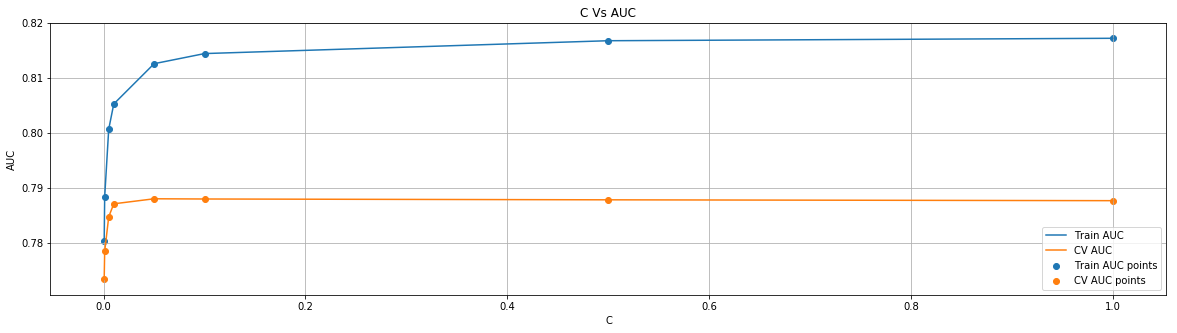

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.010771,0.002779,0.001580,0.000984,0.0005,{'C': 0.0005},0.801352,0.789150,0.759035,0.753666,...,0.773370,0.018554,8,0.773045,0.773206,0.786944,0.786087,0.782075,0.780272,0.006062
1,0.010972,0.000893,0.001018,0.000212,0.001,{'C': 0.001},0.805604,0.794812,0.766892,0.756478,...,0.778462,0.018551,7,0.782419,0.781246,0.794327,0.794019,0.789825,0.788367,0.005580
2,0.012964,0.001262,0.001113,0.000569,0.005,{'C': 0.005},0.808075,0.801338,0.772254,0.762727,...,0.784735,0.017267,6,0.796202,0.794774,0.805382,0.805788,0.801072,0.800644,0.004545
3,0.013164,0.000977,0.001425,0.000779,0.01,{'C': 0.01},0.809691,0.802730,0.774983,0.764990,...,0.787102,0.016772,5,0.801153,0.799419,0.809945,0.809919,0.805662,0.805220,0.004354
4,0.017154,0.001163,0.001403,0.000495,0.05,{'C': 0.05},0.809796,0.805121,0.780171,0.761117,...,0.788016,0.017717,1,0.809531,0.807115,0.816844,0.816771,0.812398,0.812532,0.003871
5,0.018749,0.001464,0.000946,0.000077,0.1,{'C': 0.1},0.808857,0.806730,0.781089,0.758952,...,0.787977,0.018393,2,0.811547,0.809109,0.818614,0.818466,0.814112,0.814370,0.003755
6,0.025533,0.002053,0.001315,0.000372,0.5,{'C': 0.5},0.807760,0.808835,0.782465,0.755906,...,0.787828,0.019493,3,0.813959,0.811738,0.820958,0.820561,0.816293,0.816702,0.003615
7,0.029723,0.002920,0.001128,0.000237,1,{'C': 1},0.807257,0.809790,0.782269,0.754899,...,0.787673,0.019943,4,0.814321,0.812255,0.821318,0.821006,0.816826,0.817145,0.003587


In [98]:
lr = LogisticRegression(penalty='l2', class_weight='balanced')
parameters = {'C':[0.0005, 0.001, 0.005, 0.01, 0.05, 0.1,  0.5, 1]}
clf = GridSearchCV(lr, parameters, cv=5, scoring='roc_auc')
clf.fit(x_train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']
cv_auc = results['mean_test_score'] 
C =  results['param_C']

plt.figure(figsize=(20,5))
plt.plot(C, train_auc, label='Train AUC')
plt.plot(C, cv_auc, label='CV AUC')
plt.scatter(C, train_auc, label='Train AUC points')
plt.scatter(C, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("C")
plt.ylabel("AUC")
plt.title("C Vs AUC")
plt.grid()
plt.show()
results

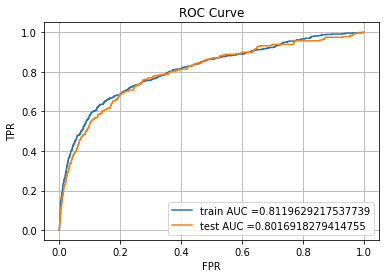

In [99]:
lr = LogisticRegression(penalty='l2', C=0.1, class_weight='balanced')
lr.fit(x_train, y_train)

y_train_pred = lr.predict_proba(x_train)[:,1]
y_test_pred = lr.predict_proba(x_test)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

In [100]:
#Function for a threshold
def best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    print("best threshold:", t)
    print(50*"=")
    return t

def prediction(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [101]:
t = best_threshold(tr_thresholds, train_fpr, train_tpr)

print("Test Accuracy Score")
print(accuracy_score(y_test, prediction(y_test_pred, t)))
print(50*"=")

print("Test F1 Score")
print(f1_score(y_test, prediction(y_test_pred, t)))
print(50*"=")

print("Train confusion matrix")
print(confusion_matrix(y_train, prediction(y_train_pred, t)))
print(50*"=")

print("Test confusion matrix")
print(confusion_matrix(y_test, prediction(y_test_pred, t)))

best threshold: 0.4959931471686409
Test Accuracy Score
0.8118932038834952
Test F1 Score
0.4252163164400495
Train confusion matrix
[[4267  849]
 [ 216  434]]
Test confusion matrix
[[1835  359]
 [ 106  172]]


# Random Forest

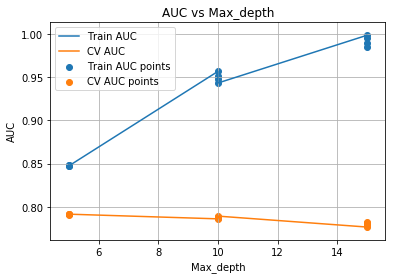

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.976739,0.049309,0.336868,0.008246,5,2,"{'max_depth': 5, 'min_samples_split': 2}",0.819828,0.763876,0.790061,0.791260,0.022861,4,0.835940,0.863879,0.845542,0.848454,0.011590
1,2.026575,0.042691,0.369204,0.051067,5,4,"{'max_depth': 5, 'min_samples_split': 4}",0.820625,0.764281,0.789705,0.791542,0.023042,3,0.835594,0.863316,0.845330,0.848080,0.011483
2,2.031444,0.096954,0.341185,0.005184,5,6,"{'max_depth': 5, 'min_samples_split': 6}",0.820725,0.764684,0.789919,0.791781,0.022920,1,0.835190,0.862521,0.844695,0.847468,0.011329
3,2.002413,0.073692,0.338582,0.007222,5,8,"{'max_depth': 5, 'min_samples_split': 8}",0.820906,0.764357,0.789990,0.791756,0.023123,2,0.834969,0.862969,0.844130,0.847356,0.011656
4,2.251351,0.166334,0.377661,0.054544,10,2,"{'max_depth': 10, 'min_samples_split': 2}",0.816992,0.761619,0.780416,0.786348,0.022995,8,0.950560,0.960113,0.958935,0.956536,0.004253
5,2.270240,0.137487,0.420952,0.051462,10,4,"{'max_depth': 10, 'min_samples_split': 4}",0.818418,0.762762,0.782984,0.788061,0.023006,6,0.945137,0.955708,0.954351,0.951732,0.004696
6,2.346188,0.064472,0.334801,0.000241,10,6,"{'max_depth': 10, 'min_samples_split': 6}",0.818556,0.763127,0.781993,0.787898,0.023013,7,0.940280,0.951786,0.950411,0.947492,0.005131
7,2.213987,0.098604,0.338744,0.006298,10,8,"{'max_depth': 10, 'min_samples_split': 8}",0.819950,0.765546,0.783017,0.789511,0.022682,5,0.935869,0.946885,0.946707,0.943154,0.005152
8,2.348017,0.048452,0.336511,0.003708,15,2,"{'max_depth': 15, 'min_samples_split': 2}",0.810868,0.761311,0.758413,0.776873,0.024077,15,0.998432,0.998116,0.998429,0.998326,0.000148
9,2.525605,0.060961,0.407544,0.050238,15,4,"{'max_depth': 15, 'min_samples_split': 4}",0.812111,0.763543,0.761664,0.779115,0.023353,12,0.995383,0.994152,0.994253,0.994596,0.000558


In [102]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000, class_weight='balanced', random_state=42, n_jobs=-1)
parameters = {'max_depth':[5,10,15,None], 'min_samples_split':[2,4,6,8]}
clf = GridSearchCV(rfc, parameters, cv=3, scoring='roc_auc')
clf.fit(x_train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])

train_auc= results['mean_train_score']
cv_auc = results['mean_test_score'] 
Max_depth =  results['param_max_depth']

plt.plot(Max_depth, train_auc, label='Train AUC')
plt.plot(Max_depth, cv_auc, label='CV AUC')
plt.scatter(Max_depth, train_auc, label='Train AUC points')
plt.scatter(Max_depth, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("Max_depth")
plt.ylabel("AUC")
plt.title("AUC vs Max_depth")
plt.grid()
plt.show()
results


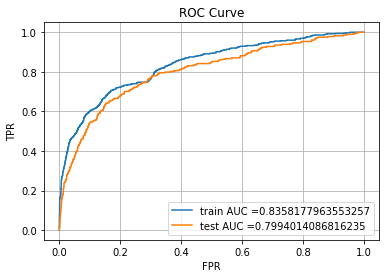

In [103]:
rfc = RandomForestClassifier(n_estimators=3000, class_weight='balanced', max_depth=5, random_state=42, min_samples_split=6, n_jobs=-1)
rfc.fit(x_train, y_train)

y_train_pred = rfc.predict_proba(x_train)[:,1]
y_test_pred = rfc.predict_proba(x_test)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

In [104]:
t = best_threshold(tr_thresholds, train_fpr, train_tpr)

print("Test Accuracy Score")
print(accuracy_score(y_test, prediction(y_test_pred, t)))
print(50*"=")

print("Test F1 Score")
print(f1_score(y_test, prediction(y_test_pred, t)))
print(50*"=")

print("Train confusion matrix")
print(confusion_matrix(y_train, prediction(y_train_pred, t)))
print(50*"=")

print("Test confusion matrix")
print(confusion_matrix(y_test, prediction(y_test_pred, t)))

best threshold: 0.4961907196128812
Test Accuracy Score
0.80542071197411
Test F1 Score
0.4321133412042503
Train confusion matrix
[[4251  865]
 [ 191  459]]
Test confusion matrix
[[1808  386]
 [  95  183]]


# KNN

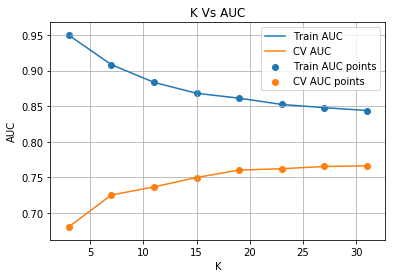

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.049967,0.013537,0.140440,0.045940,3,{'n_neighbors': 3},0.724467,0.730453,0.675667,0.646455,...,0.680350,0.041781,8,0.949630,0.944985,0.948900,0.953091,0.952156,0.949752,0.002842
1,0.052308,0.016386,0.116568,0.004865,7,{'n_neighbors': 7},0.750500,0.766967,0.728671,0.672562,...,0.725158,0.033153,7,0.904972,0.902936,0.910578,0.912578,0.910878,0.908388,0.003740
2,0.051571,0.009891,0.200307,0.045936,11,{'n_neighbors': 11},0.766147,0.765370,0.747387,0.685743,...,0.736566,0.030801,6,0.880718,0.873706,0.884895,0.889821,0.888322,0.883492,0.005811
3,0.055643,0.021828,0.222899,0.001652,15,{'n_neighbors': 15},0.770328,0.777010,0.751402,0.723400,...,0.749800,0.021856,5,0.861126,0.860521,0.869585,0.876745,0.872611,0.868118,0.006378
4,0.042732,0.004292,0.207166,0.045843,19,{'n_neighbors': 19},0.782215,0.783751,0.764103,0.739898,...,0.760231,0.021491,4,0.850791,0.851358,0.866388,0.868012,0.869618,0.861234,0.008359
5,0.053440,0.014866,0.211579,0.051768,23,{'n_neighbors': 23},0.781622,0.782758,0.769201,0.743180,...,0.762167,0.020013,3,0.843471,0.843546,0.857308,0.859136,0.858487,0.852390,0.007275
6,0.048669,0.013443,0.237428,0.015333,27,{'n_neighbors': 27},0.781205,0.778461,0.773622,0.752530,...,0.765278,0.015941,2,0.840164,0.841201,0.849168,0.853852,0.855098,0.847897,0.006222
7,0.052858,0.007202,0.236349,0.007881,31,{'n_neighbors': 31},0.789153,0.778419,0.769520,0.743785,...,0.766201,0.017023,1,0.838634,0.840922,0.841682,0.848077,0.850205,0.843904,0.004443


In [107]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_jobs=-1)
parameters = {'n_neighbors':[3,7,11,15,19,23,27,31]}
clf = GridSearchCV(neigh, parameters, cv=5, scoring='roc_auc')
clf.fit(x_train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']
cv_auc = results['mean_test_score'] 
K =  results['param_n_neighbors']

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("K")
plt.ylabel("AUC")
plt.title("K Vs AUC")
plt.grid()
plt.show()
results


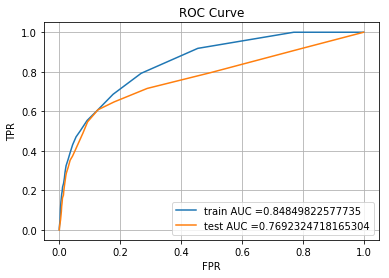

In [108]:
neigh = KNeighborsClassifier(n_neighbors=27, n_jobs=-1)
neigh.fit(x_train, y_train)

y_train_pred = neigh.predict_proba(x_train)[:,1]  
y_test_pred = neigh.predict_proba(x_test)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

In [109]:
t = best_threshold(tr_thresholds, train_fpr, train_tpr)

print("Test Accuracy Score")
print(accuracy_score(y_test, prediction(y_test_pred, t)))
print(50*"=")

print("Test F1 Score")
print(f1_score(y_test, prediction(y_test_pred, t)))
print(50*"=")

print("Train confusion matrix")
print(confusion_matrix(y_train, prediction(y_train_pred, t)))
print(50*"=")

print("Test confusion matrix")
print(confusion_matrix(y_test, prediction(y_test_pred, t)))

best threshold: 0.1111111111111111
Test Accuracy Score
0.7115695792880259
Test F1 Score
0.3582358235823582
Train confusion matrix
[[3740 1376]
 [ 135  515]]
Test confusion matrix
[[1560  634]
 [  79  199]]
